In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
import timeit

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [18]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [84]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= locations

In [124]:
#only not null, not zero and less that 10 hours to solve
df1 = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 28800) & (df['Respond to Available'] > 5)]

In [125]:
dum_list = ['Unit Type', 'Call Type']

for col in dum_list:
    dummies = pd.get_dummies(df1[col], prefix=col, drop_first=True)
    df1[dummies.columns]= dummies

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [126]:
df1 = df1.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm', 'Minutes',
                      'Supervisor District', 'Neighborhooods - Analysis Boundaries', 'Original Priority','Station Area',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay', 'Weekofyear',  
                      'RowID', 'Battalion', 'ALS Unit', 'Fire Prevention District', 'Call Type_Electrical Hazard',
                        'Unit Type', 'Call Type', 'Call Type_Oil Spill', 'Call Type_Watercraft in Distress',
                        'Call Type_Lightning Strike (Investigation)', 'Call Type_Smoke Investigation (Outside)',
                        'Call Type_Marine Fire','Call Type_High Angle Rescue', 'Call Type_Mutual Aid / Assist Outside Agency',
                       ], errors='ignore')

df1 = df1.dropna(how='any') 

In [127]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## XGBOOST

In [37]:
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import math

In [145]:
xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.1, gamma=0, max_depth=8, silent=0)
xgb.fit(X_train,y_train)

KeyboardInterrupt: 

In [136]:
y_pred_xgb = xgb.predict(X_test)
print(explained_variance_score(y_test, y_pred_xgb))

0.6476059733278446


In [137]:
xgb.score(X_test,y_test)

0.6408416309137495

In [139]:
mean_absolute_error(y_test, y_pred_xgb)

603.513379566995

In [140]:
mean_squared_error(y_test, y_pred_xgb)

1010935.8278500035

In [141]:
mean_squared_error(y_test, y_pred_xgb)**0.5

1005.4530460692848

In [143]:
print(xgb.feature_importances_)

[0.06106234 0.1072612  0.02098715 0.158983   0.1452435  0.09044048
 0.01751836 0.11772572 0.11105943 0.01172412 0.01391392 0.0081972
 0.01561925 0.00265488 0.00930178 0.00877856 0.01331318 0.01228611
 0.00075577 0.00441835 0.00187974 0.00372071 0.00079453 0.00058136
 0.00085266 0.00071701 0.00096894 0.00234482 0.00224793 0.00079453
 0.00897235 0.00141465 0.00866229 0.00513536 0.01674321 0.00075577
 0.00443773 0.00114334 0.00257737 0.00401139]


In [144]:
val = xgb.feature_importances_
feat = X_test.columns

list(zip(feat,val))

[('Zipcode of Incident', 0.06106234),
 ('Box', 0.1072612),
 ('Number of Alarms', 0.020987151),
 ('Unit sequence in call dispatch', 0.158983),
 ('Call to Dispatch', 0.1452435),
 ('Hours', 0.09044048),
 ('Hospital or Transport', 0.017518362),
 (0, 0.117725715),
 (1, 0.111059435),
 ('Unit Type_CHIEF', 0.011724125),
 ('Unit Type_ENGINE', 0.01391392),
 ('Unit Type_INVESTIGATION', 0.008197198),
 ('Unit Type_MEDIC', 0.015619247),
 ('Unit Type_PRIVATE', 0.0026548845),
 ('Unit Type_RESCUE CAPTAIN', 0.009301784),
 ('Unit Type_RESCUE SQUAD', 0.008778559),
 ('Unit Type_SUPPORT', 0.01331318),
 ('Unit Type_TRUCK', 0.012286107),
 ('Call Type_Aircraft Emergency', 0.00075577),
 ('Call Type_Alarms', 0.004418348),
 ('Call Type_Assist Police', 0.0018797356),
 ('Call Type_Citizen Assist / Service Call', 0.003720714),
 ('Call Type_Confined Space / Structure Collapse', 0.00079452747),
 ('Call Type_Elevator / Escalator Rescue', 0.0005813615),
 ('Call Type_Explosion', 0.0008526636),
 ('Call Type_Extrication / 

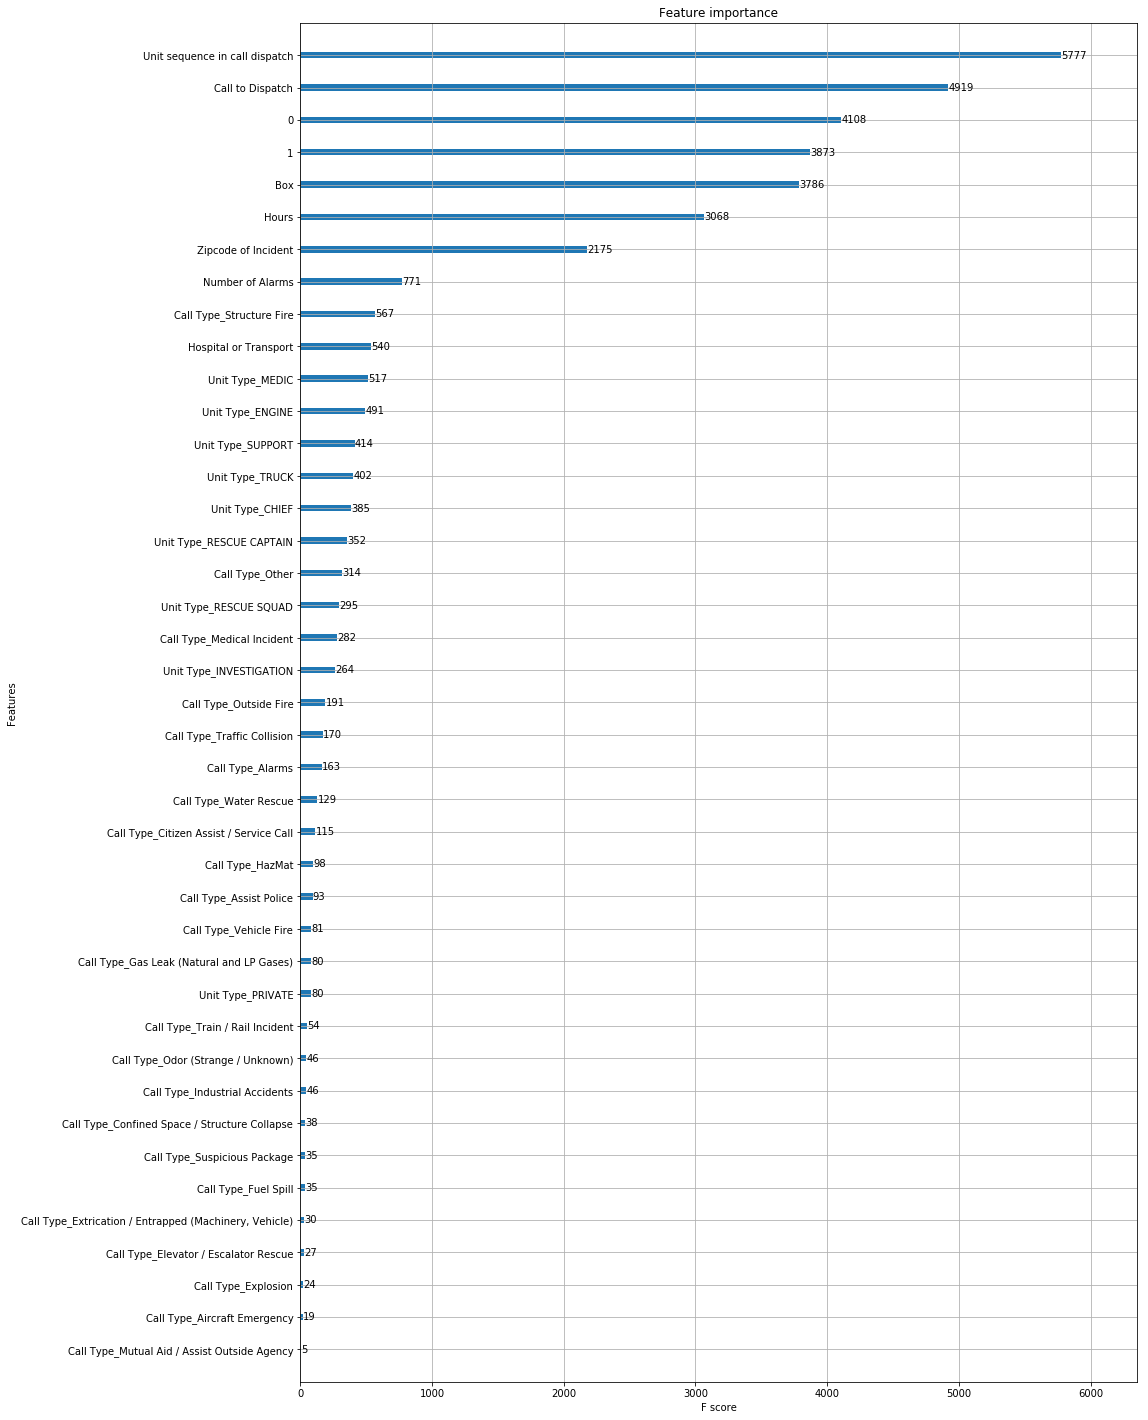

In [104]:
plot_importance(xgb)
plt.rcParams['figure.figsize'] = [15, 25]
pyplot.show()

In [18]:
learn_list = [0.1,0.11]
start_time = timeit.default_timer()

for learn in learn_list:
    xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=learn, gamma=0, max_depth=5)
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    score = xgb.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('rate= '+ str(learn))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

rate= 0.1
score is: 0.6333922713090718
MAE: 612.0414620838025
mse: 1045330.9467060082
mse: 1022.4142735241953
rate= 0.11
score is: 0.6329708224398108
MAE: 612.071904111071
mse: 1046532.6495371679
mse: 1023.0017837409512
It took:1427.3878783429973 seconds to run it.


In [14]:
n_estimators_list = [50,100,150,200]
start_time = timeit.default_timer()

for n_estimators in n_estimators_list:
    xgb = xgboost.XGBRegressor(n_estimators=n_estimators, learning_rate=0.1, gamma=0, max_depth=5)
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    score = xgb.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('N = '+ str(n_estimators))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

N = 50
score is: 0.6230726244088721
MAE: 626.0313474434748
mse: 1074755.9844769714
mse: 1036.7043862533676
N = 100
score is: 0.6295412562856825
MAE: 618.3816357456749
mse: 1056311.5804055573
mse: 1027.770198247428
N = 150
score is: 0.6318852607220526
MAE: 614.3420155920176
mse: 1049627.9777840218
mse: 1024.513532260078
N = 200
score is: 0.6333922713090718
MAE: 612.0414620838025
mse: 1045330.9467060082
mse: 1022.4142735241953
It took:1715.6459243400022 seconds to run it.


In [15]:
learn_list = [0.07,0.05,0.02]
start_time = timeit.default_timer()

for learn in learn_list:
    xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=learn, gamma=0, max_depth=5)
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    score = xgb.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('rate= '+ str(learn))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

rate= 0.07
score is: 0.6263554635133801
MAE: 622.4929815146712
mse: 1065395.4253822344
mse: 1032.1799384711148
rate= 0.05
score is: 0.6214245857469383
MAE: 628.2020744712057
mse: 1079455.137494937
mse: 1038.9683043745545
rate= 0.02
score is: 0.551243426127665
MAE: 680.166101438472
mse: 1279566.9526159689
mse: 1131.1794519951152
It took:1104.822937731864 seconds to run it.


In [16]:
depth_list = [3,7,9,11]
start_time = timeit.default_timer()

for depth in depth_list:
    xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, max_depth=depth)
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    score = xgb.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('depth is = '+ str(depth))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

depth is = 3
score is: 0.6188970266107026
MAE: 631.849000432819
mse: 1086662.1208124221
mse: 1042.4308709993302
depth is = 7
score is: 0.6336596355818434
MAE: 611.4621056176042
mse: 1044568.5946700339
mse: 1022.0413859869051
depth is = 9
score is: 0.6338652562982448
MAE: 608.3619731455807
mse: 1043982.2957971058
mse: 1021.7545183639296
depth is = 11
score is: 0.6326556896064828
MAE: 607.1291552755716
mse: 1047431.2069794157
mse: 1023.4408663813537
It took:1987.9699813239276 seconds to run it.


In [18]:
learn_list = [0.1,0.11]
start_time = timeit.default_timer()

for learn in learn_list:
    xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=learn, gamma=0, max_depth=5)
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    score = xgb.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('rate= '+ str(learn))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

rate= 0.1
score is: 0.6333922713090718
MAE: 612.0414620838025
mse: 1045330.9467060082
mse: 1022.4142735241953
rate= 0.11
score is: 0.6329708224398108
MAE: 612.071904111071
mse: 1046532.6495371679
mse: 1023.0017837409512
It took:1427.3878783429973 seconds to run it.


In [19]:
start_time = timeit.default_timer()

xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, max_depth=7)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
score = xgb.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
print('rate= '+ str(learn))
print('score is: '+ str(score))
print('MAE: '+ str(mae))
print('mse: '+ str(mse))
print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

rate= 0.11
score is: 0.6348217272073032
MAE: 607.9550056744237
mse: 1041255.052035953
mse: 1020.4190570721192
It took:942.7323760990985 seconds to run it.


In [21]:
start_time = timeit.default_timer()

xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, max_depth=8)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
score = xgb.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
print('rate= '+ str(learn))
print('score is: '+ str(score))
print('MAE: '+ str(mae))
print('mse: '+ str(mse))
print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

rate= 0.11
score is: 0.6343156537075906
MAE: 606.807163990301
mse: 1042698.0502303615
mse: 1021.1258738423787
It took:1102.6480920049362 seconds to run it.


In [22]:
start_time = timeit.default_timer()

xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, max_depth=9)
print(str(start_time))

xgb.fit(X_train,y_train)
print('fitted')
y_pred = xgb.predict(X_test)
score = xgb.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
print('rate= '+ str(learn))
print('score is: '+ str(score))
print('MAE: '+ str(mae))
print('mse: '+ str(mse))
print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

1188597.304075528
fitted
rate= 0.11
score is: 0.6328239496659852
MAE: 606.1966863226825
mse: 1046951.4368231222
mse: 1023.2064487790927
It took:1306.9745296761394 seconds to run it.


AttributeError: 'XGBRegressor' object has no attribute 'to_graphviz'

In [123]:
df1[df1['Call to Dispatch'] ==0]

,Zipcode of Incident,Box,Number of Alarms,Unit sequence in call dispatch,Respond to Available,Call to Dispatch,Hours,Hospital or Transport,0,1,Unit Type_CHIEF,Unit Type_ENGINE,Unit Type_INVESTIGATION,Unit Type_MEDIC,Unit Type_PRIVATE,Unit Type_RESCUE CAPTAIN,Unit Type_RESCUE SQUAD,Unit Type_SUPPORT,Unit Type_TRUCK,Call Type_Aircraft Emergency,Call Type_Alarms,Call Type_Assist Police,Call Type_Citizen Assist / Service Call,Call Type_Confined Space / Structure Collapse,Call Type_Elevator / Escalator Rescue,Call Type_Explosion,"Call Type_Extrication / Entrapped (Machinery, Vehicle)",Call Type_Fuel Spill,Call Type_Gas Leak (Natural and LP Gases),Call Type_HazMat,Call Type_Industrial Accidents,Call Type_Medical Incident,Call Type_Mutual Aid / Assist Outside Agency,Call Type_Odor (Strange / Unknown),Call Type_Other,Call Type_Outside Fire,Call Type_Structure Fire,Call Type_Suspicious Package,Call Type_Traffic Collision,Call Type_Train / Rail Incident,Call Type_Vehicle Fire,Call Type_Water Rescue
954,94110,5424.0,1,1,3511.0,0.0,10,1,37.762099,-122.414999,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2667,94108,1323.0,1,1,2744.0,0.0,14,1,37.787568,-122.406590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4282,94124,6721.0,1,5,2546.0,0.0,8,0,37.724805,-122.370666,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4283,94124,6721.0,1,11,2244.0,0.0,8,0,37.724805,-122.370666,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4811,94112,8371.0,1,1,1278.0,0.0,0,1,37.711408,-122.456038,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6114,94109,3161.0,1,1,1290.0,0.0,16,0,37.785686,-122.421393,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6532,94109,1642.0,1,1,3998.0,0.0,17,1,37.784960,-122.419548,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7321,94108,1313.0,1,1,3397.0,0.0,13,1,37.793832,-122.406220,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7435,94110,5472.0,1,2,69.0,0.0,21,0,37.755437,-122.418748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8970,94124,6721.0,1,9,965.0,0.0,8,0,37.724805,-122.370666,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
